In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/EWC/EWC

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/EWC/EWC


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from copy import deepcopy

In [3]:
from utils import Model, EWC, get_accuracy, test, sgd_train, ewc_train
from load_dataset import Permutation, permute_mnist, custom_data

In [4]:
permute1 = torch.from_numpy(np.random.permutation(28*28)).long()
permute2 = torch.from_numpy(np.random.permutation(28*28)).long()
permute3 = torch.from_numpy(np.random.permutation(28*28)).long()

mnist_train1, mnist_test1 = permute_mnist(permute1)
mnist_train2, mnist_test2 = permute_mnist(permute2)
mnist_train3, mnist_test3 = permute_mnist(permute3)

In [5]:
train1, train2, train3 = custom_data(mnist_train1), custom_data(mnist_train2), custom_data(mnist_train3)
test1, test2, test3 = custom_data(mnist_test1), custom_data(mnist_test2), custom_data(mnist_test3)

In [6]:
mnist1, mnist2, mnist3 = DataLoader(train1, batch_size = 100), DataLoader(train2, batch_size = 100), DataLoader(train3, batch_size = 100)
valid1, valid2, valid3 = DataLoader(test1, batch_size = 100), DataLoader(test2, batch_size = 100), DataLoader(test3, batch_size = 100)

In [7]:
model1 = Model(28*28, 10)
model2 = deepcopy(model1)

In [8]:
num_tasks = 3
lamb = 200
train = [mnist1, mnist2, mnist3]
evalset = [valid1, valid2, valid3]
epoch = 50
acc1 = [[],[],[]] # accuracy of training with plain SGD
acc2 = [[],[],[]] # accuracy of training with EWC
optimizer1 = torch.optim.SGD(model1.parameters(), lr = 2e-3)
optimizer2 = torch.optim.SGD(model2.parameters(), lr = 2e-3)
criterion = nn.CrossEntropyLoss()
trainset = [train1,train2,train3]
sample_size = 400

In [9]:
# Training with EWC
ewc_list = []

for i in range(num_tasks):
    sample = []
    # Training with plain SGD for the first task
    if i==0:
      for _ in range(epoch):
        sgd_train(model2, train[i], optimizer2, criterion)
        for old_task in range(i+1):
            acc2[old_task].append(test(model2, evalset[old_task]))
    else:
        for _ in range(epoch + 10*i):
            ewc_train(model2, train[i], optimizer2, criterion, ewc_list, lamb)
            for old_task in range(i+1):
                acc2[old_task].append(test(model2, evalset[old_task]))
    # Compute FIM
    ewc_list.append(EWC(model2, trainset[i]))
    ewc_list[i].Fisher_matrix(sample_size*(i+1))

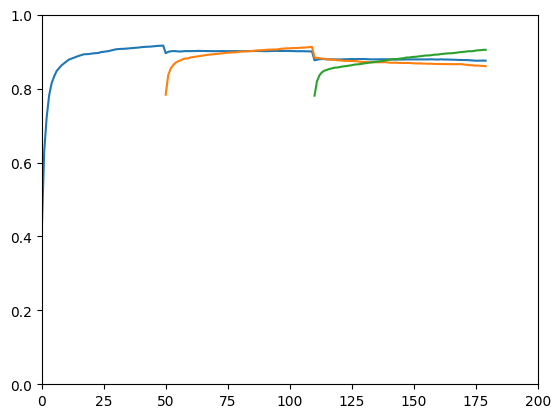

In [10]:
plt.xlim(0,200)
plt.ylim(0,1)
for i in range(len(acc2)):
  if i == 0:
    plt.plot(range(0,len(acc2[i])), acc2[i])
  else:
    plt.plot(range(epoch*i + (i-1)*10, epoch*num_tasks+10*num_tasks), acc2[i])

In [11]:
# Training with plain SGD
for i in range(num_tasks):
    for _ in range(epoch):
        sgd_train(model1, train[i], optimizer1, criterion)
        for old_task in range(i+1):
            acc1[old_task].append(test(model1, evalset[old_task]))

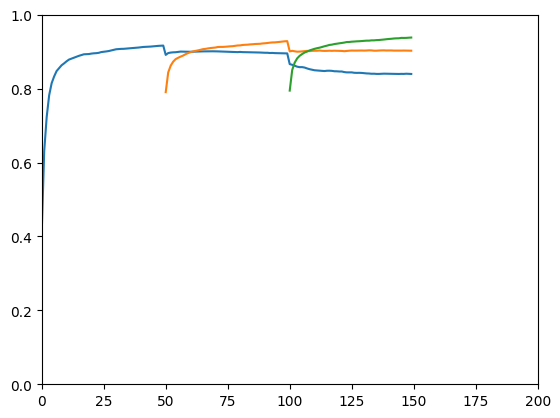

In [12]:
plt.xlim(0,200)
plt.ylim(0,1)
for i in range(len(acc1)):
  plt.plot(range(epoch*i, epoch*num_tasks), acc1[i])